# Land Use Classification using MicrosoftML
In this notebook, we illustrate how one can produce a deep learning model to classify aerial images based on land use type (developed, forested, cultivated, etc.). We apply transfer learning with MicrosoftML to adapt a pretrained featurizer for our classification use case.

<a name="prep"></a>
## Prepare deep learning framework-specific input files

If you have not generated your own training and validation sets through image extraction, download the following files and decompress them in your VM's temporary (`D:\`) storage:
- [Balanced training image set (~3 GB)](https://mawahstorage.blob.core.windows.net/aerialimageclassification/imagesets/balanced_training_set.zip)
- [Balanced validation image set (~1 GB)](https://mawahstorage.blob.core.windows.net/aerialimageclassification/imagesets/balanced_validation_set.zip)

The image sets linked above contain raw PNG images sorted into folders by their assigned label. 

Update the `image_dir` variable below to reflect the directory where your training and validation sets have been saved. The `label_to_number_dict` variable specifies the correspondence between the label names and a numeric code; it does not need to be modified unless you have changed the labeling scheme.

In [ ]:
# Autoreload when modules are changed
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score

import revoscalepy as revo
import microsoftml as ml

import land_use.connection_settings as cs
import land_use.land_use_classification_utils as luc

image_dir = cs.IMAGE_DIR
label_to_number_dict = cs.LABELS



# Show matplotlib plots inline
%matplotlib inline

# Set recursion limit to be slightly larger to accommodate larger formulas (which are paresed recursively)
print("Old recursion limit: ", sys.getrecursionlimit())
sys.setrecursionlimit(1500)
print("New recursion limit: ", sys.getrecursionlimit())

ImportError: No module named 'connection_settings'

In [2]:
# Connect to SQL Server
connection_string = cs.get_connection_string()
sql = revo.RxInSqlServer(connection_string=connection_string)
local = revo.RxLocalSeq()
revo.rx_set_compute_context(local)

DRIVER={ODBC Driver 13 for SQL Server};SERVER=TYLER-LAPTOP\TYLERSQLSERVER;PORT=21816;DATABASE=land_use_database;Trusted_Connection=Yes


## Featurize Images

In [3]:
train_data = luc.gather_image_paths(image_dir, label_to_number_dict, connection_string, mode="train")
train_data = train_data.sample(n=5000)
print(train_data.head())
print("Train Data: ", train_data.shape)

val_data = luc.gather_image_paths(image_dir, label_to_number_dict, connection_string, mode="val")
print("Val Data: ", val_data.shape)

test_data = luc.gather_image_paths(image_dir, label_to_number_dict, connection_string, mode="test")
print("Test Data: ", test_data.shape)

Rows Read: 44184, Total Rows Processed: 44184, Total Chunk Time: 19.763 seconds 
\\Tyler-laptop\tylersqlserver\FileTableData\TrainData\Shrub\ortho_1-1_hn_s_ca025_2016_1_100087.png
                                                   image       class  label
43009  \\Tyler-laptop\tylersqlserver\FileTableData\Tr...  Herbaceous      4
20749  \\Tyler-laptop\tylersqlserver\FileTableData\Tr...  Cultivated      3
25274  \\Tyler-laptop\tylersqlserver\FileTableData\Tr...   Developed      5
12726  \\Tyler-laptop\tylersqlserver\FileTableData\Tr...      Barren      0
14242  \\Tyler-laptop\tylersqlserver\FileTableData\Tr...      Barren      0
Train Data:  (5000, 3)
Rows Read: 5880, Total Rows Processed: 5880, Total Chunk Time: 2.215 seconds 
\\Tyler-laptop\tylersqlserver\FileTableData\ValData\Shrub\ortho_1-1_hn_s_ca073_2016_1_1005.png
Val Data:  (5880, 3)
Rows Read: 5880, Total Rows Processed: 5880, Total Chunk Time: 2.699 seconds 
\\Tyler-laptop\tylersqlserver\FileTableData\TestData\Shrub\ortho_1-1_

In [4]:
refeatureize = True
if refeatureize:
    revo.rx_set_compute_context(local)
    luc.compute_features(train_data, output_table=cs.TABLE_TRAIN_FEATURES, connection_string=connection_string)
    revo.rx_set_compute_context(local)

Beginning processing data.
Rows Read: 10, Read Time: 0, Transform Time: 0
Beginning processing data.
Elapsed time: 00:00:08.9053791
Finished writing 10 rows.
Writing completed.
Rows Read: 5000, Total Rows Processed: 5000Beginning processing data.
Rows Read: 5000, Read Time: 0, Transform Time: 0
Beginning processing data.
Elapsed time: 00:23:36.2822509
Finished writing 5000 rows.
Writing completed.
Total Rows written: 5000, Total time: 1.586
, Total Chunk Time: 1421.616 seconds 


In [6]:
refeatureize = True
if refeatureize:
    revo.rx_set_compute_context(local)
    luc.compute_features(val_data, output_table=cs.TABLE_VALIDATION_FEATURES, connection_string=connection_string)
    revo.rx_set_compute_context(local)

Beginning processing data.
Rows Read: 10, Read Time: 0, Transform Time: 0
Beginning processing data.
Elapsed time: 00:00:06.9032812
Finished writing 10 rows.
Writing completed.
Rows Read: 5880, Total Rows Processed: 5880Beginning processing data.
Rows Read: 5880, Read Time: 0, Transform Time: 0
Beginning processing data.
Elapsed time: 00:28:34.4578852
Finished writing 5880 rows.
Writing completed.
Total Rows written: 5880, Total time: 2.904
, Total Chunk Time: 1721.880 seconds 


In [7]:
refeatureize = True
if refeatureize:
    revo.rx_set_compute_context(local)
    luc.compute_features(test_data, output_table=cs.TABLE_TEST_FEATURES, connection_string=connection_string)
    revo.rx_set_compute_context(local)

Beginning processing data.
Rows Read: 10, Read Time: 0, Transform Time: 0
Beginning processing data.
Elapsed time: 00:00:07.4124860
Finished writing 10 rows.
Writing completed.
Rows Read: 5880, Total Rows Processed: 5880Beginning processing data.
Rows Read: 5880, Read Time: 0, Transform Time: 0
Beginning processing data.
Elapsed time: 00:25:30.9375699
Finished writing 5880 rows.
Writing completed.
Total Rows written: 5880, Total time: 9.757
, Total Chunk Time: 1545.923 seconds 


## Train Model

In [8]:
train_features_sql = revo.RxSqlServerData(table=cs.TABLE_TRAIN_FEATURES, connection_string=connection_string)

In [9]:
formula = luc.create_formula(train_features_sql, is_dataframe=False)
print(formula)

label ~ f0 + f1 + f2 + f3 + f4 + f5 + f6 + f7 + f8 + f9 + f10 + f11 + f12 + f13 + f14 + f15 + f16 + f17 + f18 + f19 + f20 + f21 + f22 + f23 + f24 + f25 + f26 + f27 + f28 + f29 + f30 + f31 + f32 + f33 + f34 + f35 + f36 + f37 + f38 + f39 + f40 + f41 + f42 + f43 + f44 + f45 + f46 + f47 + f48 + f49 + f50 + f51 + f52 + f53 + f54 + f55 + f56 + f57 + f58 + f59 + f60 + f61 + f62 + f63 + f64 + f65 + f66 + f67 + f68 + f69 + f70 + f71 + f72 + f73 + f74 + f75 + f76 + f77 + f78 + f79 + f80 + f81 + f82 + f83 + f84 + f85 + f86 + f87 + f88 + f89 + f90 + f91 + f92 + f93 + f94 + f95 + f96 + f97 + f98 + f99 + f100 + f101 + f102 + f103 + f104 + f105 + f106 + f107 + f108 + f109 + f110 + f111 + f112 + f113 + f114 + f115 + f116 + f117 + f118 + f119 + f120 + f121 + f122 + f123 + f124 + f125 + f126 + f127 + f128 + f129 + f130 + f131 + f132 + f133 + f134 + f135 + f136 + f137 + f138 + f139 + f140 + f141 + f142 + f143 + f144 + f145 + f146 + f147 + f148 + f149 + f150 + f151 + f152 + f153 + f154 + f155 + f156 + f15

In [10]:
retrain = True
if retrain:
    model = ml.rx_neural_network(formula=formula,
                               data=train_features_sql,
                               num_hidden_nodes=100,
                               num_iterations=100,
                               max_norm = 0,
                               init_wts_diameter=0.1,
                               mini_batch_size=10,
                               method="multiClass",
                               verbose=2,
                               compute_context=sql)
    luc.insert_model(cs.TABLE_MODELS, connection_string, model, "rx_neural_network")

Elapsed time: 00:00:00.5290000
Rows Read: 1, Total Rows Processed: 1
Total Rows written: 1, Total time: 0.007
, Total Chunk Time: 0.035 seconds 


## Score Model

In [11]:
model = luc.retrieve_model(cs.TABLE_MODELS, connection_string, "rx_neural_network")

Rows Read: 1, Total Rows Processed: 1, Total Chunk Time: 0.040 seconds 


In [12]:
val_features_sql = revo.RxSqlServerData(table=cs.TABLE_VALIDATION_FEATURES, connection_string=connection_string)
predictions = ml.rx_predict(model, data=val_features_sql, extra_vars_to_write=["label", "image"])

number_to_label_dict = {}
for label, number in label_to_number_dict.items():
    number_to_label_dict["Score."+str(number)] = label
print(number_to_label_dict)
    
predictions=predictions.rename(columns = number_to_label_dict)

predictions_sql = revo.RxSqlServerData(table=cs.TABLE_VAL_PREDICTIONS, connection_string=connection_string)
revo.rx_data_step(predictions, predictions_sql, overwrite=True)
print(predictions.head())

Beginning read starting with row: 1
Rows Read: 5880, Read Time: 1.2, Transform Time: 0
Beginning read starting with row: 5880
No rows remaining. Finished reading data set. 
Elapsed time: 00:00:02.4770028
Finished writing 5880 rows.
Writing completed.
{'Score.5': 'Developed', 'Score.0': 'Barren', 'Score.3': 'Cultivated', 'Score.2': 'Shrub', 'Score.1': 'Forest', 'Score.4': 'Herbaceous'}
Rows Read: 5880, Total Rows Processed: 5880
Total Rows written: 5880, Total time: 0.138
, Total Chunk Time: 0.233 seconds 
                                               image  label    Barren  \
0  \\Tyler-laptop\tylersqlserver\FileTableData\Va...    2.0  0.009191   
1  \\Tyler-laptop\tylersqlserver\FileTableData\Va...    2.0  0.002185   
2  \\Tyler-laptop\tylersqlserver\FileTableData\Va...    2.0  0.003531   
3  \\Tyler-laptop\tylersqlserver\FileTableData\Va...    2.0  0.003625   
4  \\Tyler-laptop\tylersqlserver\FileTableData\Va...    2.0  0.001661   

     Forest     Shrub  Cultivated  Herbaceous  Dev

## Analyze Model

Confusion matrix, without normalization


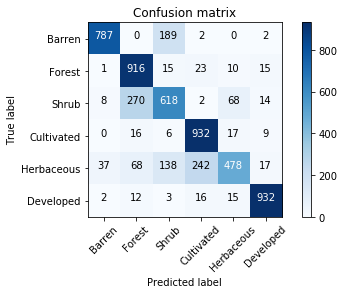

In [13]:
# Confusion matrix
class_probs = np.array(predictions.drop(["label", "image"], axis=1))
y_pred = np.argmax(class_probs, axis=1)
y_true = np.array(predictions["label"])
cm = confusion_matrix(y_true, y_pred)
luc.plot_confusion_matrix(cm, ["Barren", "Forest", "Shrub", "Cultivated", "Herbaceous", "Developed"])

In [14]:
# Accuracy (all classes)
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy (all classes): ", accuracy)

Accuracy (all classes):  0.793027210884


In [15]:
# Accuracy (Undeveloped, Cultivated, Developed)
y_true = luc.merge_classes(y_true)
y_pred = luc.merge_classes(y_pred)

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy (Undeveloped, Cultivated, Developed): ", accuracy)

Accuracy (Undeveloped, Cultivated, Developed):  0.929761904762


## Evaluate Final Model on Test Set
Only run this section once, with the final model based on validation results, in order to prevent overfitting to the test set.

In [16]:
model = luc.retrieve_model(cs.TABLE_MODELS, connection_string, "rx_neural_network")

Rows Read: 1, Total Rows Processed: 1, Total Chunk Time: 0.044 seconds 


In [17]:
test_features_sql = revo.RxSqlServerData(table=cs.TABLE_TEST_FEATURES, connection_string=connection_string)
predictions = ml.rx_predict(model, data=test_features_sql, extra_vars_to_write=["label", "image"])

number_to_label_dict = {}
for label, number in label_to_number_dict.items():
    number_to_label_dict["Score."+str(number)] = label
print(number_to_label_dict)

predictions=predictions.rename(columns = number_to_label_dict)

predictions_sql = revo.RxSqlServerData(table=cs.TABLE_TEST_PREDICTIONS, connection_string=connection_string)
revo.rx_data_step(predictions, predictions_sql, overwrite=True)
print(predictions.head())

Beginning read starting with row: 1
Rows Read: 5880, Read Time: 1.15, Transform Time: 0
Beginning read starting with row: 5880
No rows remaining. Finished reading data set. 
Elapsed time: 00:00:02.7024889
Finished writing 5880 rows.
Writing completed.
{'Score.5': 'Developed', 'Score.0': 'Barren', 'Score.3': 'Cultivated', 'Score.2': 'Shrub', 'Score.1': 'Forest', 'Score.4': 'Herbaceous'}
Rows Read: 5880, Total Rows Processed: 5880
Total Rows written: 5880, Total time: 0.609
, Total Chunk Time: 0.687 seconds 
                                               image  label    Barren  \
0  \\Tyler-laptop\tylersqlserver\FileTableData\Te...    2.0  0.005034   
1  \\Tyler-laptop\tylersqlserver\FileTableData\Te...    2.0  0.001845   
2  \\Tyler-laptop\tylersqlserver\FileTableData\Te...    2.0  0.002336   
3  \\Tyler-laptop\tylersqlserver\FileTableData\Te...    2.0  0.002957   
4  \\Tyler-laptop\tylersqlserver\FileTableData\Te...    2.0  0.025673   

     Forest     Shrub  Cultivated  Herbaceous  De

In [18]:
class_probs = np.array(predictions.drop(["label", "image"], axis=1))
y_pred = np.argmax(class_probs, axis=1)
y_true = np.array(predictions["label"])

# Accuracy (all classes)
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy (all classes): ", accuracy)

Accuracy (all classes):  0.792346938776


In [19]:
# Accuracy (Undeveloped, Cultivated, Developed)
y_true = luc.merge_classes(y_true)
y_pred = luc.merge_classes(y_pred)

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy (Undeveloped, Cultivated, Developed): ", accuracy)

Accuracy (Undeveloped, Cultivated, Developed):  0.929931972789
